<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/CNN%2CFastAPI%2CONNX%2Ctflite%20etc%20with%20Human%20Emotion%20Detection/Human_Emotions_Detection_SKELETON_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CHECKING FOR GPU AVAILABILITY**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: GPU device not found

## **DOWNLOADING AND IMPORTING NECESSARY LIBRARIES**

In [ ]:
!pip install wandb
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import datetime
import io
import wandb
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, RandomCrop, RandomZoom, Resizing, Rescaling, RandomContrast, Activation, GlobalAveragePooling2D, Add, Embedding, LayerNormalization, MultiHeadAttention, Permute
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, F1Score, AUC, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import L1, L2
from tensorflow.image import flip_left_right, flip_up_down, rot90, resize, transpose, central_crop, random_crop, random_brightness, adjust_brightness, adjust_contrast
from tensorboard.plugins.hparams import api as hp
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Feature, Features
import albumentations as A
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from google.colab import drive

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## **DOWNLOADING DATA FROM KAGGLE INTO A DIRECTORY**

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:03<00:00, 70.8MB/s]
100% 309M/309M [00:03<00:00, 87.3MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## **CONFIGURATION**

In [ ]:
configuration = {
    "batch_size": 32,
    "im_size": 256,
    "learning_rate": 1e-3,
    "n_epochs": 20,
    "dropout_rate": 0.0,
    "regularization_rate": 0.0,
    "n_filters": 6,
    "kernel_size": 3,
    "n_strides": 1,
    "pool_size": 2,
    "n_dense_1": 1024,
    "n_dense_2": 128,
    "num_classes": 3,
    "patch_size": 16,
    "proj_dim": 768,
    "class_names": ["angry", "happy", "sad"],
}


## **WANDB**

In [ ]:
!wandb login

In [ ]:
wandb.init(project = 'emotion_detection', entity = 'jagaadhep')

In [ ]:
wandb.config = configuration

## **DATASET CREATION FOR TRAIN, VAL AND TEST**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/Emotions Dataset/Emotions Dataset/train",
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = configuration['class_names'], #ONLY NEEDED IF LABELS = 'INFERRED'
    color_mode = 'rgb',
    batch_size = configuration["batch_size"],
    image_size = (configuration["im_size"], configuration["im_size"]),
    shuffle = True,
    seed = 99,
    #validation_split = 0.2,
    #subset = "validation"
    )

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/Emotions Dataset/Emotions Dataset/test",
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = configuration['class_names'], #ONLY NEEDED IF LABELS = 'INFERRED'
    color_mode = 'rgb',
    batch_size = configuration["batch_size"],
    image_size = (configuration["im_size"], configuration["im_size"]),
    shuffle = True,
    seed = 99,
    )

Found 2278 files belonging to 3 classes.


In [ ]:
'''for i in train_dataset.take(1):
  print(i)'''

'for i in train_dataset.take(1):\n  print(i)'

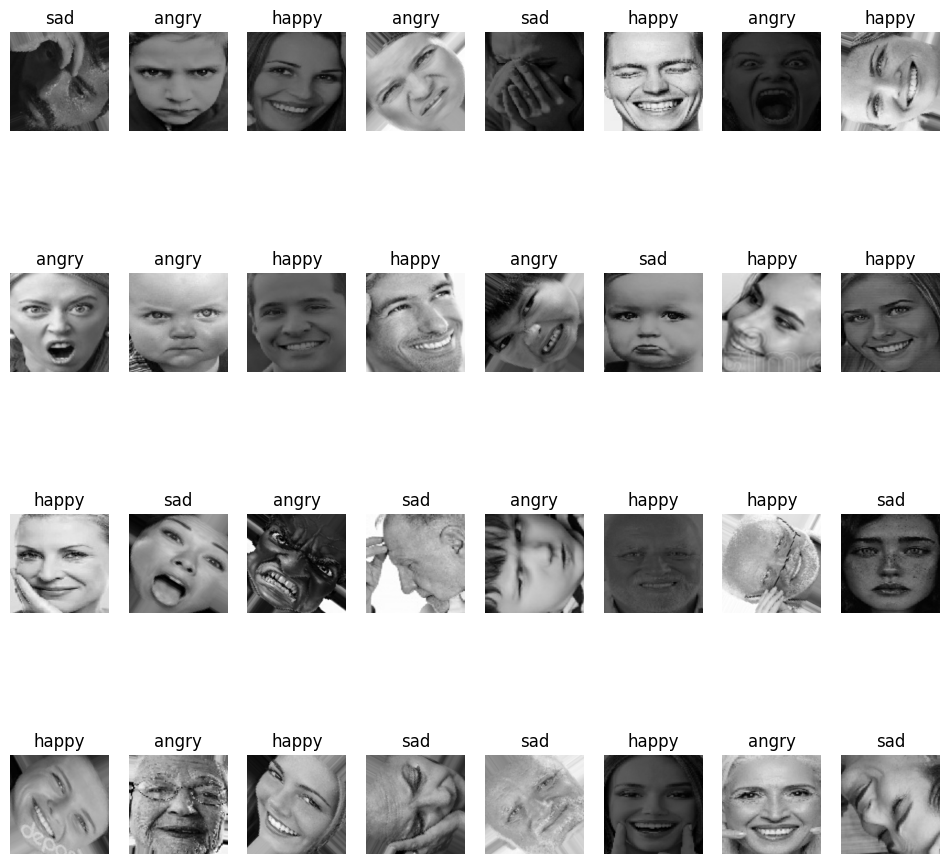

In [ ]:
plt.figure(figsize = (12,12))
for images, labels in train_dataset.take(1): #1 HERE REFERS TO 1 BATCH WHICH CONTAINS 32 LABELLED IMAGES
  for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i]/255.)
    plt.title(configuration['class_names'][tf.argmax(labels[i], axis = 0).numpy()]) #tensor_name.numpy() CONVERTS TENSOR TO NUMPY ARRAY
    plt.axis("off")

## **DATA AUGMENTATION**

In [ ]:
#tf.keras.layers augmentation
augment_layers = Sequential([
    RandomRotation(factor = (-0.025, 0.025)), #WE ROTATE BY SMALL ANGLES SO AS TO NOT GET UNUSUAL IMAGES BY ROTATING THEM AT UNUSUAL ANGLES
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [ ]:
@tf.function
def augment_layer(image, labels):
  return augment_layers(image, training = True), labels

**CUTMIX AUGMENTATION**

In [ ]:
def box(lamda):
  r_x = tf.cast(tfp.distribution.Uniform(0,configuration['im_size']).sample(1)[0], dtype = tf.int32) #im_size = width #r_x = center x coordinate
  r_y = tf.cast(tfp.distribution.Uniform(0,configuration['im_size']).sample(1)[0], dtype = tf.int32) #im_size = height  #r_y = center y coordinate

  r_w = tf.cast(configuration['im_size'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)  #im_size = width  #r_w = width of image
  r_h = tf.cast(configuration['im_size'] * tf.math.sqrt(1 - lamda), dtype = tf.int32)  #im_size = height #r_h = height of image

  r_x = tf.clip_by_value(r_x - (r_w//2), 0, configuration['im_size']) #r_x = top left corner's x coordinate clipped to not extend beyond the image
  r_y = tf.clip_by_value(r_y - (r_h//2), 0, configuration['im_size']) #r_y = top left corner's y coordinate clipped to not extend beyond the image

  x_b_r = tf.clip_by_value(r_x + (r_w//2), 0, configuration['im_size']) #x_b_r = bottom right corner's x coordinate clipped to not extend beyond the image
  y_b_r = tf.clip_by_value(r_x + (r_w//2), 0, configuration['im_size']) #y_b_r = bottom right corner's y coordinate clipped to not extend beyond the image

  r_w = x_b_r - r_x
  if r_w == 0:
    r_w = 1
  r_h = y_b_r - r_y
  if r_h == 0:
    r_h = 1
  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image1, label1), (image2, label2) = train_dataset_1, train_dataset_2
  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image2, r_y, r_x, r_h, r_w)
  pad_2 = tf.pad_to_bounding_box(crop_2, r_y, r_x, configuration['im_size'], configuration['im_size'])

  crop_1 = tf.image.crop_to_bounding_box(image1, r_y, r_x, r_h, r_w)
  pad_1 = tf.pad_to_bounding_box(crop_1, r_y, r_x, configuration['im_size'], configuration['im_size'])

  image = image1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w * r_h)/(configuration['im_size'] * configuration['im_size']), dtype = tf.float32)
  label = lamda * tf.cast(label1, dtype = tf.float32) + (1 - lamda) * tf.cast(label2, dtype = tf.float32)

  return image, label

## **DATASET PREPARATION**

In [ ]:
#FOR CUTMIX AUGMENTATION

# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [ ]:
training_dataset = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

## **MODELING**

### **LENET MODEL**

In [ ]:
#resizing and rescaling using tf.keras.layers
resize_rescale_layer = Sequential([
    Resizing(configuration['im_size'], configuration['im_size']),
    Rescaling(1.0/255)
])

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),

    #used for data agumentation with tf.keras.layers :
    resize_rescale_layer,

    Conv2D(filters = configuration['n_filters'], kernel_size = configuration['kernel_size'], strides = configuration['n_strides'], padding = 'valid', activation = 'relu', kernel_regularizer  = L2(configuration['regularization_rate'] )),
    BatchNormalization(),
    MaxPooling2D(pool_size = configuration['pool_size'], strides = configuration['n_strides'] * 2), #(2,2) can also be given as 2
    Dropout(rate = configuration['dropout_rate']),

    Conv2D(filters = configuration['n_filters'] * 2 + 4, kernel_size = configuration['kernel_size'], strides = configuration['n_strides'], padding = 'valid', activation = 'relu', kernel_regularizer  = L2(configuration['regularization_rate'] )),
    BatchNormalization(),
    MaxPooling2D(pool_size = configuration['pool_size'], strides = configuration['n_strides'] * 2), #(2,2) can also be given as 2

    Flatten(),

    Dense(configuration['n_dense_1'], activation = 'relu', kernel_regularizer  = L2(configuration['regularization_rate'])),
    BatchNormalization(),
    Dropout(rate = configuration['dropout_rate']),
    Dense(configuration['n_dense_2'], activation = 'relu', kernel_regularizer  = L2(configuration['regularization_rate'])),
    BatchNormalization(),
    Dense(configuration['num_classes'], activation = 'softmax')
])
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_3 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)     

### **ResNet 34**

**CustomConv2D**

In [ ]:
#CREATING A CUSTOM LAYER WITH Conv2D and BatchNormalization LAYERS
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = "valid"):
    super(CustomConv2D, self).__init__(name = "custom_conv2d")

    self.conv = Conv2D(
        n_filters,
        kernel_size,
        strides = n_strides,
        padding = padding,
        activation = 'relu',
        )

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):
    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

**ResidualBlock**

In [ ]:
#CREATING RESIDUAL BLOCK LAYER FOR RESIDUAL LEARNING
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = "res_block")

    self.dotted = (n_strides != 1)
    #If self.dotted = True, the output of the residual block and the inputs to be added to it have different shapes.
    #This is represented by a dotted line in the diagramatical representation of the model compared to the undotted line if self.dotted = False


    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides) #kernel_size = (1,1) here so the input and output of this layer have the same shape

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add]) #tf.keras.layers.Add layer
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

**COMPLETE NETWORK**

In [ ]:
class ResNet34(Model):
  def __init__(self):
    super(ResNet34, self).__init__(name = "resnet_34")

    self.conv_1 = CustomConv2D(64, 7, 2, padding = "same")
    self.max_pool = MaxPooling2D(3, 2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(configuration["num_classes"], activation = "softmax")

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### **EFFICIENTNET B4**

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (configuration['im_size'], configuration['im_size'], 3)
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
#TO FREEZE THE WEIGHTS TO PREVENT THEIR UPDATION DURING TRAINING
backbone.trainable = False

In [ ]:
efficient_net_model = Sequential([
    Input(shape = (configuration['im_size'], configuration['im_size'], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(configuration['n_dense_1'], activation = 'relu'),
    BatchNormalization(),
    Dense(configuration['n_dense_2'], activation = 'relu'),
    Dense(configuration['num_classes'], activation = 'softmax')
]
)

efficient_net_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_43 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                      

### **FINETUNING EFFICIENTNET**

In [ ]:
#WE FIRST DO TRANSFER LEARNING WITH trainable = False AND TRAIN WITH THIS AND THEN DO FINETUNING BY SETTING trainable = True AND TRAINING WITH THIS
#backbone.trainable = False  #TRAIN WITH THIS CONDITION FIRST
backbone.trainable = True

In [ ]:
input = Input(shape = (configuration['im_size'], configuration['im_size'],3))

x = backbone(input, training = False)
#WE SET TRAINABLE = TRUE BUT TRAINING = FALSE SO THAT BATCH NORMALIZATION LAYER'S MEAN AND VARIANCE STATISTICS DO NOT GET UPDATED
x = GlobalAveragePooling2D()(x)
x = Dense( configuration['n_dense_1'], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( configuration['n_dense_2'], activation = "relu")(x)
output = Dense( configuration['num_classes'], activation = "softmax")(x)

finetuned_efficientnet_model = Model(input, output)

finetuned_efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_44 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                             

### **VISION TRANSFORMER (ViT)**

**CREATING AND VISUALIZING PATCHES**

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image, (configuration['im_size'], configuration['im_size']))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, configuration['patch_size'], configuration['patch_size'], 1],
                           strides=[1, configuration['patch_size'], configuration['patch_size'], 1], # SO THERE IS NO SPACE BETWEEN PATCHES AND IT IS COMPACT
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


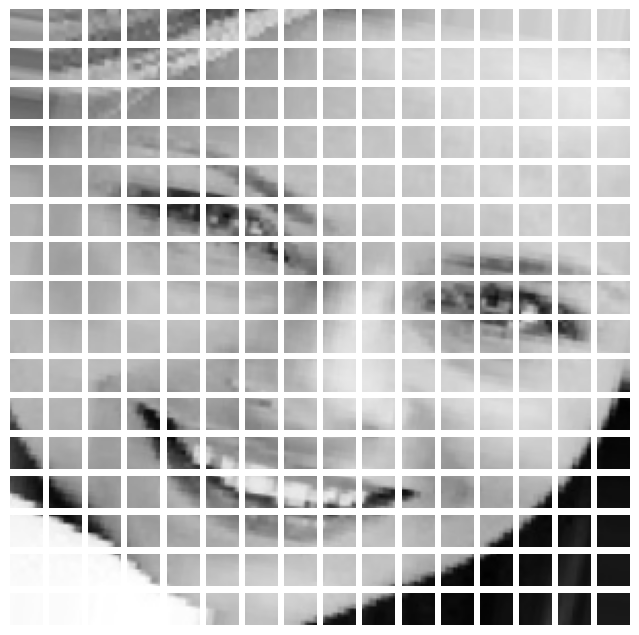

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

tf.keras.layers.Embedding

In [ ]:
model = tf.keras.Sequential()
model.add(Embedding(input_dim = 150, output_dim = 768))
input_array = np.random.randint(100, size = (25,256))
model.compile("rmsprop", "mse")
output_array = model.predict(input_array)
print(output_array.shape)

1/1 [==============================] - 0s 93ms/step
(25, 256, 768)


**PATCH ENCODER LAYER**

In [ ]:
#WE DON'T TAKE THE EXTRA POSITION ENCODING INPUT 0* INTO ACCOUNT HERE. THIS WON'T AFFECT MUCH
class PatchEncoder(Layer):
  def __init__(self, n_patches, hidden_size):
    super(PatchEncoder, self).__init__(name = "patch_encoder")

    self.linear_projection = Dense(hidden_size)
    self.positional_embedding = Embedding(n_patches, hidden_size)
    self.n_patches = n_patches

  def call(self, x):
    patches = tf.image.extract_patches(images = x,
                           sizes = [1, configuration['patch_size'], configuration['patch_size'], 1],
                           strides = [1, configuration['patch_size'], configuration['patch_size'], 1], # SO THERE IS NO SPACE BETWEEN PATCHES AND IT IS COMPACT
                           rates = [1, 1, 1, 1],
                           padding = 'VALID')
    patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
    #WE GIVE AN EMBEDDING INPUT VALUE TO EACH CONSECUTIVE PATCH AS 0,1,2...N_PATCHES-1 TO BE PASSED ON TO THE POSITIONAL EMBEDDIGN/ENCODING LAYER
    embedding_input = tf.range(start = 0, limit = self.n_patches, delta = 1)
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [ ]:
patch_encoder = PatchEncoder(256, 768)
patch_encoder(tf.zeros([1,256,256,3]))

**TRANSFORMER ENCODER LAYER**

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, n_heads, hidden_size):
    super(TransformerEncoder, self).__init__(name = "transformer_encoder")

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    self.multi_head_attention = MultiHeadAttention(num_heads = n_heads, key_dim = hidden_size)

    self.dense_1 = Dense(hidden_size, activation = tf.nn.gelu)
    self.dense_2 = Dense(hidden_size, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_attention(x_1, x_1)
    x_1 = Add()([x_1,input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

In [ ]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1,256,768]))

**VISION TRANSFORMER**
**(ViT) MODEL**

In [ ]:
class ViT(Model):
  def __init__(self, n_heads, hidden_size, n_patches, n_layers, n_dense_units):
    super(ViT, self).__init__(name = "vision_transformer")
    self.n_layers = n_layers
    self.patch_encoder = PatchEncoder(n_patches, hidden_size)
    self.transformer_encoders = [TransformerEncoder(n_heads, hidden_size) for _ in range(n_layers)]
    self.dense_1 = Dense(n_dense_units, tf.nn.gelu)
    self.dense_2 = Dense(n_dense_units, tf.nn.gelu)
    self.dense_3 = Dense(configuration['num_classes'], activation = 'softmax')

  def call(self, input, training = True):
    x = self.patch_encoder(input)
    for i in range(self.n_layers):
      x = self.transformer_encoders[i](x)
    #MLP HEAD
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(n_heads = 4, hidden_size = 768, n_patches = 256, n_layers = 2, n_dense_units = 128)
vit(tf.zeros([2,256,256,3]))

In [ ]:
vit.summary()

THIS MODEL MAY NOT NECESSARILY DO WELL DUE TO NOT BEING TRAINED ON A DATASET THAT IS LARGE ENOUGH

### **HUGGINGFACE ViT**

In [ ]:
!pip install transformers

In [ ]:
from transformers import ViTConfig, ViTModel
configuration = ViTConfig()
model = ViTModel(configuration)

In [ ]:
#TO ACCESS THE CONFIGURATION OF THE MODEL
configuration_ = model.config
print(configuration_)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.38.2"
}



**MODEL**

In [ ]:
resize_rescale_hf = Sequential([
    Resizing(224,224),
    Rescaling(1./255),
    Permute((3,1,2)) #WE REORDER THE DIMENSIONS OF THE INPUT IMAGE BECAUSE THE MODEL ACCEPTS IMAGES IN THE FORMAT (NUM_CHANNELS, HEIGHT, WIDTH)
])

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:] #IN base_model.vit(x)[0][:,0,:], WE SPECIFY [0][:,0,:] TO ACCESS THE CLASS EMBEDDINGS IN THE THE .last_hidden_state (OUTPUTS OF THE LAST HIDDEN STATE)(base_model.vit(x)[0])
#print(x)
output = Dense(configuration['num_classes'], activation = 'softmax')(x)

h5_model = Model(inputs = inputs, outputs = output)

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (configuration['im_size'] ,configuration['im_size']))

In [ ]:
hf_model(tf.expand_dims(test_image, axis = 0))

In [ ]:
hf_model.summary()
#WHEN FINE TUNING OR UPDATING ALL THE PARAMETERS OF A PRETRAINED MODEL, USE LOWER(LIKE /5) LEARNING RATES THAN NORMAL LIKE 5e-5

### **MOBILENETV2**

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = ( configuration["im_size"], configuration["im_size"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(  configuration["n_dense_1"], activation = "relu"),
    BatchNormalization(),
    Dense( configuration["n_dense_2"], activation = "relu"),
    Dense( configuration['num_classes'], activation = "softmax"),

    ])
pretrained_model.summary()

## **TRAINING**

### **CALLBACKS**

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
    )

In [ ]:
es_callback = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True )

In [ ]:
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
metric_directory = "./logs/" + current_time + "/metrics"
train_writer = tf.summary.create_file_writer(metric_directory)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()
  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
lrs_callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
rlrop_callback = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3, verbose = 1 )

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=configuration["class_names"])

    wandb.log({"confusion_matrix": cm})

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    validation_table = wandb.Table(columns = columns)

    for im, label in validation_dataset:
      pred = configuration["class_names"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = configuration['class_names'][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]
      validation_table.add_data(*row)

    wandb.log({"Model Results" : validation_table})


### **TRAINING**

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(),
           TopKCategoricalAccuracy(k = 2)]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = configuration['learning_rate']), loss = loss_function, metrics = metrics) #DIVIDE THE LEARNING RATE BY 100 TO GET A SMALL LEARNING RATE WHEN FINETUNING (trainable = True) PRETRAINED MODELS

In [ ]:
history = lenet_model.fit(training_dataset, validation_data = validation_dataset, epochs = configuration['n_epochs'], verbose = 1, callbacks = [checkpoint_callback, es_callback, lrs_callback, rlrop_callback, WandbCallback(), LogConfMatrix()])

## **VISUALIZING AND EVALUATING MODEL**

###**LOSS HISTORY GRAPH**

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

###**ACCURACY HISTORY GRAPH**

In [ ]:
plt.plot(history.history['acccuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

###**MODEL EVALUATION**

In [ ]:
lenet_model.load_weights('best_weights')

In [ ]:
lenet_model.evaluate(validation_dataset)

### **FEATURE MAPS VISUALIZATION USING VGG16 PRETRAINED MODEL**

In [ ]:
vgg16_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = None, #WE SET WEIGHTS = NONE HERE TO SEE A CLEARER VISUALIZATION OF FEATURE EXTRACTION DUE TO THE MODEL NOW BEING UNTRAINED
    input_shape = (configuration['im_size'], configuration['im_size'], 3)
)

In [ ]:
vgg16_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
vgg16_backbone.layers

In [ ]:
vgg16_backbone.layers[1].output

<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>

In [ ]:
#TO CHECK IF A LAYER IS CONLULUTIONAL LAYER OR NOT
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg16_backbone.layers[1:]]
#TO CHOOSE ONLY THE CONLULUTIONAL LAYERS
#feature_maps = [layer.output for layer in vgg16_backbone.layers[1:] if is_conv(layer.name)]

In [ ]:
feature_maps

NameError: name 'feature_maps' is not defined

In [ ]:
feature_map_model = Model(inputs = vgg16_backbone.input, outputs = feature_maps)
feature_map_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
test_image_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/104188.jpg_rotation_2.jpg"
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (configuration['im_size'], configuration['im_size']))
im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0) #EXPAND DIMENSION SINCE WE ARE PASSING TRAINING DATA AS BATCHES

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(len(f_maps))
for i in range(len(f_maps)):
  print(f_maps[i].shape)

18
(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 8, 8, 512)


**VISUALIZATION**

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256, 256))
  f_size = f_maps[i].shape[1] # TO GET THE KERNEL SIZE (SCALAR)
  n_channels = f_maps[i].shape[3]
  #WE VISUALIZE THE OUTPUTS FROM EACH CHANNEL OF A LAYER SIDE BY SIDE. SO WE KEEP HEIGHT AS f_size, AND WIDTH AS f_size *n_channels
  joint_maps = np.ones((f_size, f_size * n_channels)) #INITIALIZATION OF THE FEATURE MAP

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j : f_size*(j+1)] = f_maps[i][... , j] #SELECTS j th CHANNEL (LAST DIMENSION)

  plt.imshow(joint_maps[:, 0:512]) #WE SPECIFY 0:512 AND NOT WHOLE TO REDUCE RAM CONSUMPTION
  plt.axis('off')

NameError: name 'f_maps' is not defined

### **GRADCAM WITH EFFICIENT NET B5**

In [ ]:
effnet_b5_backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
effnet_b5_backbone.trainable=False

In [ ]:
x = effnet_b5_backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( configuration['n_dense_1'], activation = "relu")(x)
x = Dense( configuration['n_dense_1'], activation = "relu")(x)
output = Dense( configuration['num_classes'], activation = "softmax")(x)

pretrained_model = Model(effnet_b5_backbone.inputs, output)
pretrained_model.summary()

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (configuration['im_size'], configuration['im_size']))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
print(preds)

In [ ]:
np.argmax(preds[0])

In [ ]:
#DEFINING RECTIFIED CONVOLUTIONAL FEATURE MAPS MODEL
last_conv_layer_name = "top_activation" #GET THE NAME OF THE LAST CONVOLUTIONAL LAYER FROM MODEL SUMMARY
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

In [ ]:
classifier_layer_names = [ #GET THESE FROM pretrained_model.summary()
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
#DEFINING CLASSIFIER UNIT
classifier_input = Input(shape=(8,8,2048)) #OUTPUT SHAPE OF last_conv_layer_model.summary()
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
#CALCULATING PARTIAL DERIVATIVES FOR OUTPUT _CLASS W.R.T. EACH FEATURE MAP #BACKPROPAGATION
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy() #MEAN OF grads

In [ ]:
print(pooled_grads.shape)

In [ ]:
#MULTIPLYING RECTIFIED CONV FEATURE MAPS WITH THE MEAN OF grads
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[0]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

In [ ]:
#ADDING ALL CORRESPONDING PIXELS/UNITS OF EACH FEATURE MAP TO GET A 1 CHANNEL OUTPUT FOR VISUALIZATION IN HEATMAP AFTER PASSING THROUGH RELU ACTIVATION FUNCTION
heatmap = np.sum(last_conv_layer_output, axis=-1)
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
#RESIZE HEATMAP AND ADD WITH INPUT IMAGE TO GET GRADCAM OUTPUT
resized_heatmap=cv2.resize(np.array(heatmap),(configuration['im_size'], configuration['im_size']))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

In [ ]:
#RESIZE HEATMAP AND ADD WITH INPUT IMAGE TO GET GRADCAM OUTPUT
resized_heatmap=cv2.resize(np.array(heatmap),(configuration['im_size'], configuration['im_size']))
plt.matshow(resized_heatmap*100+img_array[0,:,:,0]/255)

## **TESTING**

In [ ]:
test_image_path = "/content/dataset/EmotionsDataset_Splitted/data/train/sad/749.jpg  "
test_image = cv2.imread(test_image_path)
#test_image = cv2.resize(test_image, (configuration['im_size'], configuration['im_size']))
im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0) #EXPAND DIMENSION SINCE WE ARE PASSING TRAINING DATA AS BATCHES
print(im.shape)
print(configuration['class_names'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

### **VISUALIZING PREDICTED VS ACTUAL LABELS FOR SOME IMAGES**

In [ ]:
plt.figure(figsize = (12,12))
for images, labels in validation_dataset.take(1): #1 HERE REFERS TO 1 BATCH WHICH CONTAINS 32 LABELLED IMAGES
  for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label - " + configuration['class_names'][tf.argmax(labels[i], axis = 0).numpy()]
              + "\n Predicted Label - " + configuration['class_names'][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])])
    plt.axis("off")

## **ONNX**

### **SAVING MODEL**

**TensorFlow SavedModel format** -  more versatile and interoperable than hdf5 format

In [ ]:
hf_model.save('vit_finetuned')

**HDF5 FORMAT** -  more convenient for use within the Keras or TensorFlow ecosystem

In [ ]:
hf_model.save('vit_finetuned.h5')

### **ONNX INSTALATION**

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime
#!pip install onnxruntime-gpu

In [ ]:
import onnxruntime as rt
rt.get_device()

### **CONVERSION FROM TensorFlow SavedModel FORMAT**

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_tf.onnx

### **CONVERSION FROM KERAS MODEL**

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, configuration['im_size'], configuration['im_size'], 3),
    tf.float32,
    name = "input"
))
output_path = "vit_keras.onnx"

model_proto, meta_data = tf2onnx.convert.from_keras(hf_model, input_signature = spec, opset = 13, output_path = output_path)

output_names = [n.names for n in model_proto.graph.output]

In [ ]:
print(output_names)

### **INFERENCE**

In [ ]:
test_image_path = "/content/dataset/EmotionsDataset_Splitted/data/train/sad/749.jpg  "
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (configuration['im_size'], configuration['im_size']))
im = test_image.astype(np.float32)
im = np.expand_dims(im, axis = 0)

In [ ]:
import time

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers = providers)

t1 = time.time()

n_predictions = 10
for _ in range(n_predictions):
  onnx_prediction = m.run(output_names, {"input": im})

print("Time for a single prediction ", (time.time() - t1)/n_predictions) # WE TAKE AVG OF MANY PREDICTIONS TO GET A BETTER VIEW OF PREDICTION/INFERENCE TIME

In [ ]:
print(onnx_prediction)

**TO COMPARE THE PREDICTION/INFERENCE TIME WITH TENSORFLOW MODEL**

In [ ]:
t1 = time.time()
for _ in range(n_predictions):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/n_predictions)

**RESULTS (AVERAGE PREDICTION TIME AND FILE SIZE)**

In [ ]:
tf, cpu = 0.8s
tf, gpu = 0.15s
tf_size = 1000MB

onnx, cpu = 0.5s
onnx, gpu = 0.025s
onnx_size = 328MB

onnx_quantized, cpu = 0.4s
onnx_quantized, gpu = 0.3s
onnx_quantized_size = 83MB

### **QUANTIZATION WITH ONNX**

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_float32 = output_path
model_quantized = '/content/vit_quantized.onnx'

quantized_model = quantize_dynamic(model_float32, model_quantized, weight_type = QuantType.QUInt8)

**CALCULATING ACCURACY DROP**

In [ ]:
def accuracy(model):
  total, accuracy = 0,0
  for im, label in validation_dataset:
    onnx_prediction = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_prediction, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acccuray += 1

    total += 1
  return accuracy/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print("ONNX model accuracy : ",accuracy(m_q))
print("Quantized model accuracy : ",accuracy(m))

## **QUANTIZATION WITH TENSORFLOW (ALSO TFLITE)**

In [ ]:
!pip install-q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

### **QUANTIZATION AWARE TRAINING**

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape = (configuration['im_size'], configuration['im_size'], 3)
)

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( configuration['n_dense_1'], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( configuration['n_dense_2'], activation = "relu")(x)
output = Dense( configuration['num_classes'], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

**QUANTIZING A MODEL**

In [ ]:
#quant_aware = tfmot.quantization.keras.quantize_model(lenet_model)
#THIS GIVES ERROR WHEN QUANTIZING LAYERS LIKE Resizing() AND BatchNormalization() BECAUSE THEY HAVE NO PARAMETERS

**QUANTIZING ONLY CERTAIN LAYERS OF A MODEL**

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_model = tf.keras.models.clone_model(pretrained_func_model, clone_function=apply_quantization_to_conv)

In [ ]:
quant_aware_model.summary()

In [ ]:
quantization_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_model)
quantization_aware_model.summary()

### **POST TRAINING QUANTIZATION AND TFLITE**

In [ ]:
pretrained_model.load_weights("/content/vit_finetuned.h5")
pretrained_model.evaluate(validation_dataset)

In [ ]:
def representative_data_gen():
  for input_value,j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen
#WE USE .representative_dataset ONLY WITH STATIC QUANTIZATION
#WE DO DYNAMIC QUANTIZATION IF WE DON'T SPECIFY IT

In [ ]:
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"vit_model.tflite"
tflite_model_file.write_bytes(tflite_model)

TFLITE MODEL OCCUPIES MUCH LESS SPACE THAN OTHER FORMATS

### **TFLITE RUNTIME**

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

WE CAN ALSO RUN IT ON RASPBERRY PI

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (configuration['im_size'] ,configuration['im_size']))
test_image = np.expand_dims(test_image, axis = 0)

#print(configuration['class_names'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

**INFERENCE USING TFLITE MODEL**

In [ ]:
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter(model_path = tflite_models_dir/"vit_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0] # Model has single input which we gave as uint8
output_details = interpreter.get_output_details()[0]  # Model has single output which we gave as uint8

interpreter.set_tensor(input_details['index'], test_imaage)  #Data conversion is done here automatically
interpreter.invoke()
output = interpreter.get_tensor(output_details['index'])[0] #Data conversion is done here automatically

print(configuration['class_names'][np.argmax(output)])

**ACCURACY OF QUANTIZED TFLITE MODEL**

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy(tflite_models_dir/"vit_model.tflite")

## **CONFUSION MATRIX**

In [ ]:
labels = []
predicted = []
for images, label in validation_dataset:
  predicted.append(lenet_model(images))
  labels.append(label)

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])) #WE TAKE THE LAST BATCH labels[-1](AND ALSO WITH predicted[-1]) BECAUSE IT MAY NOT NECESSARILY CONTAIN THE BATCH_SIZE NUMBER OF IMAGES. LIKE WHEN 100 IMAGES IS BATCHED INTO BATCH SIZE 32, LAST BATCH(4TH) CONTAINS 4 IMAGES ONLY
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## **TFRecords**

**STORING A DATASET AS TFRECORD**

In [ ]:
train_dataset = train_dataset.unbatch()
validation_dataset = validation_dataset.unbatch()

In [ ]:
#display(train_dataset)
#display(validation_dataset)

In [ ]:
def create_example(image, label):
  bytes_feature = Feature(bytes_list = BytesList(value = [image]))
  int_feature = Feature(int64_list = Int64List(value = [label]))

  example = Example(
      features = Features(feature = {
          'images' : bytes_feature,
          'labels' : int_feature
      }))

  return example.SerializeToString()

In [ ]:
num_shards = 10
path = 'tfrecords/train/filename.tfrecord' #CREATE A FOLDER tfrecords AND A FOLDER train INSIDE IT BEFORE EXECUTING THIS
#example : 'tfrecords/train/shard_{:02d}.tfrecord'
path_val = 'tfrecords/val/filename.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image, tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

val_encoded_dataset = validation_dataset.map(encode_image)

In [ ]:
for shard_number in range(num_shards):
  sharded_dataset = encoded_dataset.shard(num_shards, shard_number).as_numpy_iterator()
  val_sharded_dataset = val_encoded_dataset.shard(num_shards, shard_number).as_numpy_iterator()
  with tf.io.TFRecordWriter(path.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)
  with tf.io.TFRecordWriter(path_val.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in val_sharded_dataset:
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

**CREATING A TENSORFLOW DATASET FROM TFRECORD FILES**

In [ ]:
reconstruct_data = tf.data.TFRecordDataset([path.format(p) for p in range(num_shards)])
val_reconstruct_data = tf.data.TFRecordDataset([path_val.format(p) for p in range(num_shards)])

In [ ]:
def parse_tfrecords(example):
  feature_description = {
      "images" : tf.io.FixedLenFeature([], tf.string),
      "labels" : tf.io.FixedLenFeature([], tf.int64)
  }

  example = tf.io.parse_single_example(example, feature_description)
  example["images"] = tf.image.convert_image_dtype(tf.io.decode_jpeg(example["images"], channels = 3), dtype = tf.float32)

  return example["images"], example["labels"]

In [ ]:
parsed_dataset = reconstruct_data.map(parse_tfrecords).batch(configuration['batch_size']).prefetch(tf.data.AUTOTUNE)
val_parsed_dataset = val_reconstruct_data.map(parse_tfrecords).batch(configuration['batch_size']).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

**TRAINING MODEL WITH THIS DATASET**

In [ ]:
lenet_model_tfrecord = tf.keras.Sequential(
    [
    InputLayer(input_shape = (none, none, 3), ),

    resize_rescale_layers,

    Conv2d(filters = configuration["n_filters"] , kernel_size = configuration["kernel_size"], strides = configuration["n_strides"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(configuration["regularization_rate"])),
    BatchNormalization(),
    MaxPool2d (pool_size = configuration["pool_size"], strides= configuration["n_strides"]*2),
    Dropout(rate = configuration["dropout_rate"] ),

    Conv2d(filters = configuration["n_filters"]*2 + 4, kernel_size = configuration["kernel_size"], strides=configuration["n_strides"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(configuration["regularization_rate"])),
    BatchNormalization(),
    MaxPool2d (pool_size = configuration["pool_size"], strides= configuration["n_strides"]*2),

    Flatten(),

    Dense( configuration["n_dense_1"], activation = "relu", kernel_regularizer = L2(configuration["regularization_rate"])),
    BatchNormalization(),
    Dropout(rate = configuration["dropout_rate"]),

    Dense( configuration['n_dense_2'], activation = "relu", kernel_regularizer = L2(configuration["regularization_rate"])),
    BatchNormalization(),

    Dense(configuration["num_classes"], activation = "softmax"),

])

lenet_model.summary()

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model_tfrecord.compile(
    optimizer = Adam(learning_rate = configuration['learning_rate']),
    loss = loss_function,
    metrics = metrics)


In [ ]:
history = lenet_model_tfrecord.fit(
    parsed_dataset,
    validation_data = val_parsed_dataset,
    epochs = configuration["n_epochs"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

## **FASTAPI**

In [ ]:
!pip install fastapi
!pip install "uvicorn[standard]"
!pip install gunicorn

### **LEARNING FASTAPI**

**PRINTING HELLO WORLD IN FASTAPI**

In [ ]:
from fastapi import FastAPI
api = FastAPI()

@app.get("/login") #SYNTAX : fastapi_name.http_method(http_website_directory)
def read():
  return {"hello" : "world"}

# TO RUN: uvicorn file_name:fastapi_name
#e.g. uvicorn main:app

# TO AUTOMATICALLY UPDATE API AFTER EACH CODE CHANGE INSTEAD OF RERUNNING THE CODE : uvicorn file_name:fastapi_name --reload

**PRINTING USER INPUTS IN FASTAPI**

In [ ]:
from typing import Union
@app.get("/items/{item_id}")
def read_item(item_id : int, q : Union[str|None] = None):
  return {"our_item_id":item_id, "q":q}

**GETTING INPUT AND DEFINING SCHEMAS IN FASTAPI**

In [ ]:
from pydantic import BaseModel
class InputItem(BaseModel): #CREATE SCHEMA InputItem FOR INPUT DETAILS OF THE ITEM. THIS CLASS INHERITS FROM BaseModel CLASS IN pydantic
  name:str
  price:int
  discount:str
class OutputModel(BaseModel): #ANOTHER SIMILAR SCHEME FOR OUTPUT DETAILS OF ITEM.
  name: str
  selling_price:int
@app.post("/items/", response_model = OutputItem) #.post TO GET INPUT   # response_model DEFINES SCHEMA OR RETURN TYPE FOR OUTPUT IN RESPONSE BODY
def add_item(item:InputItem):
  selling_price = item.price- item.discount
  return {"name":item.name, "selling_price":selling_price}  #TO DISPLAY OUTPUT
  #KEY VALUES SHOULD BE SAME AS THE ONES IN THAT OF response_model (OutputItem HERE)

### **CREATING FASTAPI API FOR EMOTIONS DETECTION**

**service/api/endpoints/detect.py**

In [ ]:
from fastapi import APIRouter, UploadFile, HTTPException
from PIL import Image #PIL MEANS PILLOW
from io import BytesIO
from service.core.logic.onnx_inference import emotions_detector
from service.core.schemas.output import APIOutput

emo_router = APIRouter() #IN detect.py   # THIS WILL PLAY THE ROLE OF ROUTING INFORMATION FROM detect.py TO main.py

@emo_router.post("/detect", response_model = APIOutput)
# WE CREATE AN ASYNCHRONOUS API USING 'async' BEFORE 'def' IN FUNCTION DEFINITION
async def detect(im : UploadFile):  #WE WANT TO CARRY OUT DETECTIONS BASED ON INPUT IMAGES
  if im.filename.split(".")[-1] in ("jpg","jpeg","png"):
    pass
  else:
    raise HTTPException(status_code = 415, detail = "Not an image") #HTTPException RAISES ERROR IN API PAGE
  image = Image.open(BytesIO(im.file.read())) #SINCE Image.open TAKES BYTES AS INPUT WE CONVERT THE IMAGE FILE WE READ TO BYTES USING BytesIO()
  image = np.array(image)

  return emotions_detector(image)

**service/api/endpoints/test.py**

In [ ]:
from fastapi import APIRouter

test_router = APIRouter()

@test_router.get("/test")
async def testing():
  return {"testing":"testing"}

**service/api/api.py**

In [ ]:
from fastapi import APIRouter
from service.api.endpoints.detect import emo_router
from service.api.endpoints.test import test_router

main_router = APIRouter()
main_router.include_router(emo_router)
main_router.include_router(test_router)

**service/main.py**

In [ ]:
from fastapi import FastAPI
from service.api.api import main_router
import onnx_runtime as rt

app = FastAPI(project_name = "Emotions Detection")
app.include_router(main_router)

providers = ['CPUExecutionProvider']
m = rt.InferenceSession("service/vit_keras.onnx", providers = providers) #vit_keras.onnx STORED IN service/vit_keras.onnx   #MODEL IS LOADED

@app.get("/")
async def root():
  return {"hello" : "world"}

**service/core/logic/onnx_inference.py**

In [ ]:
import numpy as np
import cv2
import onnx_runtime as rt
import service.main as s
#import time

def emotions_detector(img_array):

  if len(img_array.shape) == 2: #TRUE IF IMAGE IS IN GRAYSCALE
    img_array = cv2.cvtColor(img_array, cv2.COLOR_GREY2RGB)

  # time_init = time.time()

  test_image = cv2.resize(img_array, (256,256))
  im = test_image.astype(np.float32)
  im = np.expand_dims(im, axis = 0)
  #time_elapsed_preprocess = time.time() - time_init
  onnx_prediction = s.m.run(['dense'], {"input": im})

  #time_elapsed = time.time() - time_init #TIME TAKEN TO RUN INFERENCE

  emotion = ""
  if np.argmax(onnx_prediction[0][0]) == 0:
    emotion = "angry"
  elif np.argmax(onnx_prediction[0][0]) == 1:
    emotion = "happy"
  else:
    emotion = "sad"

  return {"emotion":emotion,
          #"time_elapsed":str(time_elapsed),
          #"time_elapsed_preprocess":str(time_elapsed_preprocess)
          }

**service/core/schemas/output**

In [ ]:
from pydantic import BaseModel

class APIOutput(BaseModel):
  emotion : str
  #time_elapsed :str
  #time_elapsed_preprocess :str

**RUNNING API ON GUNICORN INSTEAD OF UVICORN**

In [ ]:
gunicorn service.main:app --workers 3 --worker_class uvicorn.workers.UvicornWorker #3 REFERS TO 3 WORKERS (NUMBER OF WORKERS)

## **HEROKU**

**WE STORE NAMES(WITH VERSIONS) OF ALL PACKAGES IN EMOTIONS_DETECTION FOLDER (FOLDER CONTAINING SERVICE FOLDER) IN A .txt FILE**

In [ ]:
pip freeze > requirements.txt

In [ ]:
fastapi==0.87.0
numpy==1.23.4
onnxruntime==1.13.1
Pillow==9.3.0
opencv-python-headless==4.2.0.32

**IN PROCFILE**

In [ ]:
web : gunicorn service.main:app --workers 3 --worker_class uvicorn.workers.UvicornWorker #3 REFERS TO 3 WORKERS (NUMBER OF WORKERS)

**runtime.txt**

In [ ]:
python-3.9.15

### **HOSTING API WITH HEROKU** (USE PYTHONANYWHERE FOR FREE)

**INSTALL HEROKU**

In [ ]:
sudo snap install heroku

**LOGIN TO HEROKU**

In [ ]:
heroku login

**CREATE A GIT REPOSITORY**

In [ ]:
cd emotion_detection/
git init

In [ ]:
git config --global --add safe.directory /home/emotions_detection

In [ ]:
heroku git:remote -a jagaa #jagaa IS PROJECT NAME

**DEPLOY APPLICATION**

In [ ]:
git add .
get commit -am "first commit"

In [ ]:
git push heroku master

**NOW WE RUN LINK THERE IN SWAGGER UI MODE AND THE CURL LINK WE GET HERE IS THE LINK OF OUR API THAT IS DEPLOYED TO CLOUD USING HEROKU**

**HEROKU LOGS**

In [ ]:
heroku logs --app app_name --tail

## **LOAD TESTING WITH LOCUSTS**

### **IN locusts.py**

In [ ]:
pip install locust

In [ ]:
from locust import SequentialTaskSet, HttpUser, task

class DetectorTask(SequentialTaskSet):
  @task
  def detection(self):
    with open("test_image.jpg","rb") as image:
      self.client.post(
          "/detect", #api endpoint file
          files = {"im":image} #input
      )

api_website_link_heroku = " " #paste link of api here
class LoadTester(HttpUser):
  host = api_website_link_heroku
  tasks = [DetectorTask]

**TO RUN LOCUSTS.PY**

In [ ]:
locust -f locusts.py

## **PRUNING**

In [ ]:
# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
  print(layer.name)
  if layer.name != "rescaling_1" and layer.name != "normalization" and layer.name != "sequential_1":

    pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.2,
                  final_sparsity=0.8, begin_step=0, end_step=2000),

          }

    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    lenet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model_for_pruning, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_dataset,
                      validation_data = validation_dataset,
                      epochs=3,
                      callbacks=callbacks)

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, pruned_keras_file = tempfile.mkstemp('eff_pruned.h5')
tf.keras.models.save_model(model_for_export, "lenet_pruned_1.h5", include_optimizer=False)
#print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  with zipfile.ZipFile("lenet_keras.zip", 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return "good"#os.path.getsize(zipped_file)

## **CLASS WEIGHTING**

In [ ]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}
print(class_weights)